In [1]:
import pickle
import numpy as np

In [2]:
with  open('/content/train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with  open('/content/test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
all_data = test_data + train_data

In [5]:
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [6]:
vocab.add('no')
vocab.add('yes')

In [7]:
vocab_len = len(vocab) + 1

In [12]:
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lens)
max_story_len

156

In [13]:
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

In [14]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [19]:
train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [20]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [21]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len):
    X = []
    Xq = []
    Y = []

    for story, question, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [22]:
inputs_train, question_train, answer_train = vectorize_stories(train_data)

In [23]:
inputs_test, question_test, answer_test = vectorize_stories(test_data)

In [32]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [33]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [34]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [35]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [36]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [37]:
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [38]:
answer = concatenate([response, question_encoded])

In [39]:
answer

<tf.Tensor 'concatenate_2/concat:0' shape=(None, 6, 220) dtype=float32>

In [40]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [41]:
answer = Activation('softmax')(answer)

In [42]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       multiple             2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
____________________________________________________________________________________________

In [43]:
history = model.fit([inputs_train, question_train], answer_train, batch_size=32, epochs=120, validation_data=([inputs_test, question_test], answer_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 11s 1ms/step - loss: 0.8758 - accuracy: 0.4874 - val_loss: 0.7004 - val_accuracy: 0.4970
Epoch 2/120
10000/10000 [==============================] - 9s 899us/step - loss: 0.7022 - accuracy: 0.4953 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 3/120
10000/10000 [==============================] - 9s 909us/step - loss: 0.6956 - accuracy: 0.5013 - val_loss: 0.6983 - val_accuracy: 0.4970
Epoch 4/120
10000/10000 [==============================] - 9s 911us/step - loss: 0.6952 - accuracy: 0.5019 - val_loss: 0.6949 - val_accuracy: 0.4970
Epoch 5/120
10000/10000 [==============================] - 9s 917us/step - loss: 0.6945 - accuracy: 0.5047 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 6/120
10000/10000 [==============================] - 9s 906us/step - loss: 0.6952 - accuracy: 0.4890 - val_loss: 0.6938 - val_accuracy: 0.4970
Epoch 7/120
10000/10000 [==============================] -

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


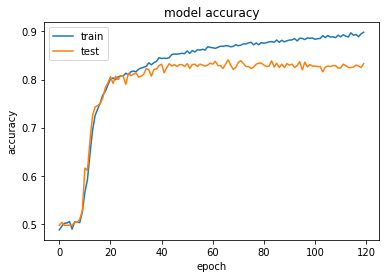

In [45]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
model.save('chatbot.h5')

In [47]:
model.load_weights('/content/chatbot.h5')
pred_results = model.predict(([inputs_test, question_test]))

In [51]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [52]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [53]:
test_data[0][2]

'no'

In [48]:
pred_results.shape

(1000, 38)

In [54]:
val_max = np.argmax(pred_results[0])

In [56]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [57]:
k

'no'

In [58]:
pred_results[0][val_max]

0.9999994

In [64]:
story = "John left the kitchen . Sandra dropped the football in the garden ."

In [65]:
story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [66]:
question = "Is the football in the garden ?"
question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [67]:
data = [(story.split(), question.split(), 'yes')]

In [68]:
story, question, answer = vectorize_stories(data)

In [69]:
pred_results = model.predict(([story, question]))

In [70]:
val_max = np.argmax(pred_results[0])

In [71]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [72]:
k

'yes'

In [74]:
pred_results[0][val_max]

0.98544693